In [4]:
from Bio import SeqIO, Entrez
import os
from urllib.error import HTTPError
import pickle
import pandas as pd
from sklearn.model_selection import train_test_split
from itertools import permutations, product
from sklearn.metrics import accuracy_score, confusion_matrix, balanced_accuracy_score
import tqdm
import numpy as np
from sklearn.model_selection import RepeatedStratifiedKFold, train_test_split, cross_val_score

from numpy import mean
from numpy import std
import pickle
from os import path
from sklearn.model_selection import cross_val_score
from warnings import simplefilter
from collections import OrderedDict
from sklearn.metrics import accuracy_score, auc, confusion_matrix, balanced_accuracy_score, precision_recall_curve, auc, roc_curve, roc_auc_score

from concurrent.futures import ThreadPoolExecutor, as_completed
import matplotlib.pyplot as plt


if (os.path.abspath('').split('/')[-1] == 'project'):
    %cd utils
elif (os.path.abspath('').split('/')[-1] == 'validate'):
    %cd ../utils

import query_utils
import model_utils
import validation_utils

if (os.path.abspath('').split('/')[-1] == 'utils'):
    %cd ..


simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
simplefilter(action='ignore', category=FutureWarning)


/Users/benjaminli/Documents/coding/scires/project/utils
/Users/benjaminli/Documents/coding/scires/project


In [2]:
df = pd.read_csv('data/info.csv')
X_train, X_test, y_train, y_test = train_test_split(df.loc[:, df.columns != 'isZoonotic'], df['isZoonotic'], test_size=0.6, random_state=None)
# X_test = df.loc[:, df.columns != 'isZoonotic']
# y_test = df['isZoonotic']

In [9]:
curr_dir = 'models/curr_models'
best_xgboost = pickle.load(open(f'{curr_dir}/xgBoost.pkl', 'rb'))
best_xgboost_params = pickle.load(open(f'{curr_dir}/xgBoost-params.pkl', 'rb'))

best_gradBoost = pickle.load(open(f'{curr_dir}/gradBoost.pkl', 'rb'))
best_gradBoost_params = pickle.load(open(f'{curr_dir}/gradBoost-params.pkl', 'rb'))

best_rF = pickle.load(open(f'{curr_dir}/randforest.pkl', 'rb'))
lrmodel = pickle.load(open(f'{curr_dir}/lrmodel.pkl', 'rb'))

nardus_gradBoost = pickle.load(open(f'{curr_dir}/nardus_gridsearch.pkl', 'rb'))

mlp = pickle.load(open(f'{curr_dir}/mlpClassifier.pkl', 'rb'))

svmmodel = pickle.load(open(f'{curr_dir}/svm.pkl', 'rb'))

regnard = pickle.load(open(f'models/nardus_testing/gradBoost.pkl', 'rb'))

knn = pickle.load(open(f'{curr_dir}/knn.pkl', 'rb'))


In [4]:
# Models within "orig_models" folder have the highest training acc but not as great cross validation

nardus_score = validation_utils.cross_validate(nardus_gradBoost.best_estimator_, X_test, y_test)
regnard_score = validation_utils.cross_validate(regnard, X_test, y_test)

# val_utils.cross_validate(mlp,X_test, y_test)

# xg_score = validation_utils.cross_validate(best_xgboost,X_test, y_test)
grad_score = validation_utils.cross_validate(best_gradBoost,X_test, y_test)
rf_score = validation_utils.cross_validate(best_rF,X_test, y_test)
lr_score = validation_utils.cross_validate(lrmodel,X_test, y_test)

GradientBoostingClassifier
gradboost


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    7.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.


Accuracy: 0.957 (0.008)
tn: 4904, fp: 12, fn: 38, tp: 704
GradientBoostingClassifier
gradboost


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    4.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.


Accuracy: 0.958 (0.008)
tn: 4897, fp: 19, fn: 28, tp: 714
GradientBoostingClassifier
gradboost


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    2.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.


Accuracy: 0.955 (0.008)
tn: 4911, fp: 5, fn: 42, tp: 700
BalancedBaggingClassifier


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    1.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.


Accuracy: 0.919 (0.011)
tn: 4693, fp: 223, fn: 28, tp: 714
LogisticRegression


KeyboardInterrupt: 

In [10]:
models = OrderedDict({
    "merged_dataset_GBM": nardus_gradBoost.best_estimator_,
    "xgboost_dataset1": best_xgboost,
    "gradboost_dataset1": best_gradBoost,
    "randomforest_dataset1": best_rF,
    "logisticregression_dataset1": lrmodel,
    "mlp_dataset1": mlp,
    "svm_dataset1": svmmodel,
    "gradboost_dataset2": regnard,
    "knn_dataset1": knn
})

In [5]:
cross_val_all = validation_utils.cross_validate_multiple(models, X_test, y_test)

GradientBoostingClassifier
gradboost


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    7.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.


Accuracy: 0.958 (0.007)
tn: 4919, fp: 9, fn: 36, tp: 694
XGBClassifier
xgboost


KeyboardInterrupt: 

In [2]:
# import os
# di = {}
# for model in os.listdir('models/searched'):
#     di[model] = pickle.load(open(f'models/searched/{model}', 'rb'))

validation_utils.draw_roc_multiple(models, X_test, y_test) # implement averaging of the ROC curves

FileNotFoundError: [Errno 2] No such file or directory: 'models/searched'

In [14]:
print(cross_val_all)
real = OrderedDict()
for key in cross_val_all:
    real[key] = round(cross_val_all[key], 2)

{'nardus': 0.9567572469433064, 'xgboost': 0.9596438287626256, 'gradboost': 0.9550489383658025, 'randomforest': 0.919641222885852, 'logisticregression': 0.9361365270959066, 'mlp': 0.9533396916726601, 'svm': 0.9403777478970575, 'regnard': 0.9575233747146564}


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0.96
0.96
0.96
0.92
0.94
0.95
0.94
0.96


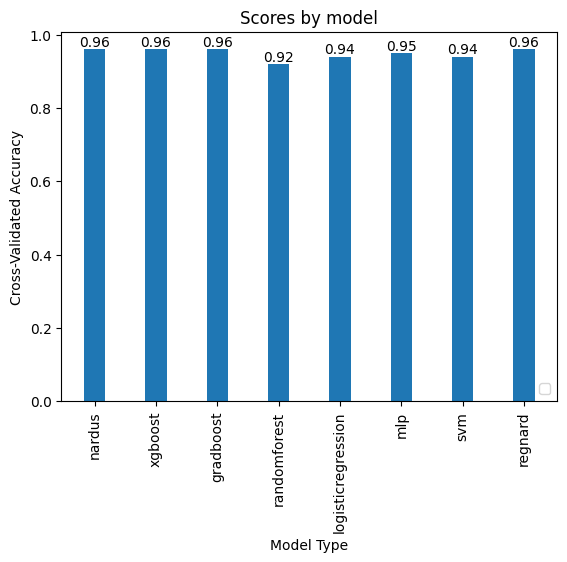

In [15]:
validation_utils.draw_accuracies(models, X_test, y_test, obj=real)

<class 'sklearn.ensemble._gb.GradientBoostingClassifier'>


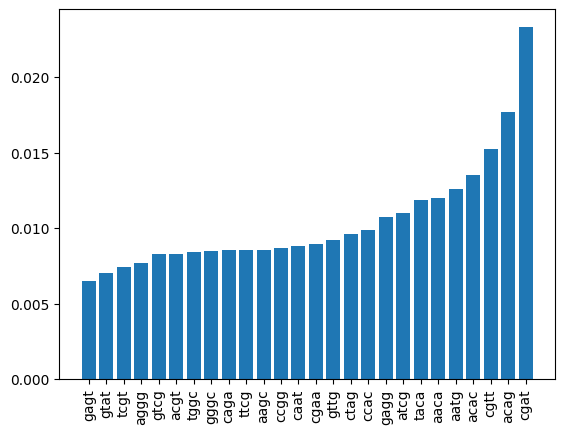

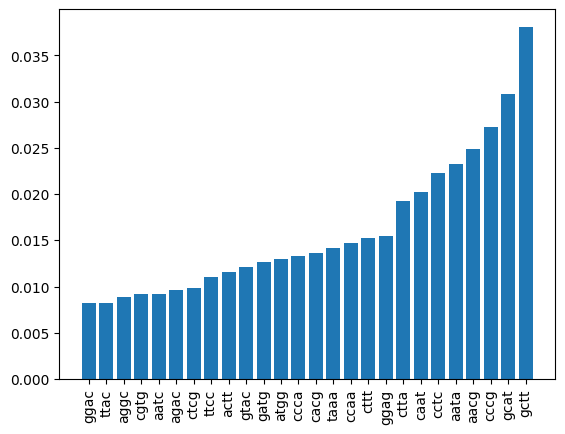

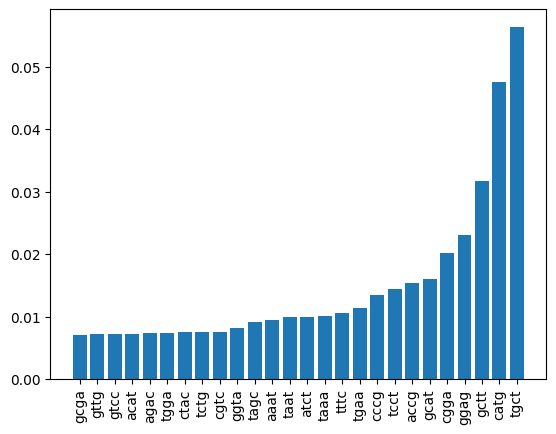

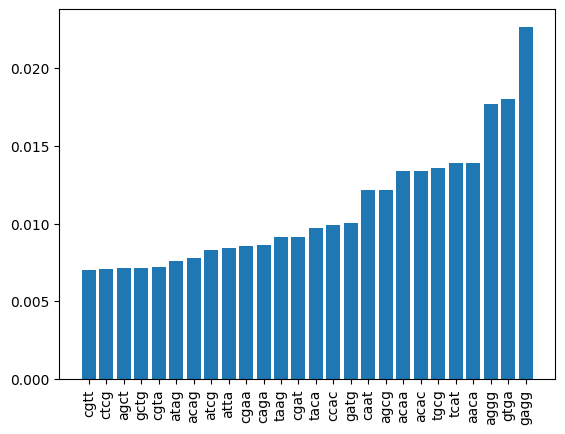

In [ ]:
"""
validation_utils.draw_roc_curve(nardus_gradBoost.best_estimator_, X_test, y_test)
validation_utils.draw_roc_curve(best_xgboost, X_test, y_test)
validation_utils.draw_roc_curve(best_rF, X_test, y_test)
validation_utils.draw_roc_curve(best_gradBoost, X_test, y_test)
validation_utils.draw_roc_curve(mlp, X_test, y_test)

"""
print(type(nardus_gradBoost.best_estimator_))
validation_utils.draw_feature_importances(nardus_gradBoost.best_estimator_, X_test)
validation_utils.draw_feature_importances(best_gradBoost, X_test)
validation_utils.draw_feature_importances(best_xgboost, X_test)
validation_utils.draw_feature_importances(regnard, X_test)

In [ ]:
max_bound = 3
for x in range(len(resrF)-max_bound+1):
    for i in range(max_bound):
        if resrF[x][0] == resgB[x+i][0]:  print("rF & gb bound", i, resrF[x], x)
        if resrF[x][0] == resxG[x+i][0]:  print("rF & xg bound", i, resrF[x], x)
        if resgB[x][0] == resxG[x+i][0]:  print("gb & xg bound", i, resgB[x], x)

rF & gb bound 1 ('cgcg', 0.0003015572826893574) 12
rF & xg bound 0 ('cgac', 0.0005925319998248206) 21
rF & gb bound 1 ('tatt', 0.0011150453509348468) 60
rF & gb bound 0 ('ctcg', 0.001601226302398424) 96
rF & xg bound 2 ('taac', 0.0016960808192351047) 105
rF & xg bound 1 ('caaa', 0.0018456698283735272) 115
gb & xg bound 1 ('agct', 0.002219047867503112) 122
rF & xg bound 1 ('ctca', 0.0020714853411268937) 132
rF & gb bound 2 ('gaac', 0.0025670387790062968) 151
gb & xg bound 0 ('taag', 0.014197001200931161) 244
